## basic_1_emissions_quantification_method in OpenTNSim

#### This notebook is used for demonstrating the emissions quantification method for inland vessels sailing over a simple waterway stretch. It is strutured as following:

- Prepare simulation input: vessel properties and waterway characteristics
- Define the simulation for a vessel sailing over the waterway
- Run the simulation to compute: 
    1) the resistance of the vessel while sailing in the waterway
    2) the power required for the vessel to overcome the resistance
    3) the energy consumed during the sailing 
    4) the emissions(CO2, PM10, NOx) emitted during the sailing 
- Extract the simulation results from OpenTNSim log

- **Assignment**: extract the emission indicators using this notebook 

### *Learning objectives*

*Real world facts understanding*
- *the students should understand the linkage among resistance, power, energy, and emissions.*
- *emission indicators*
*Practical coding skills*
- *the student should be able to extract the resistance, power, energy from OpenTNSim log*
- *the student should be able to extract the emission indicators from OpenTNSim log*

### 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


#### Prepare simulation input: vessel properties and waterway characteristics

vessel

In [2]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": 4,  # m/s
    "V_g_ave":4,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000,
}             



waterway characteristics

In [3]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [4,0]
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6]
width = [150]
current_speeds = [2]  # [m/s]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [4]:
V_g_profile_up = [4.5] # [m/s] vessel sailing speed for upstream
V_g_profile_down = [4.5] # [m/s] vessel sailing speed for downstream


In [5]:
# create a graph 
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):

    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "WaterwayWidth": width[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

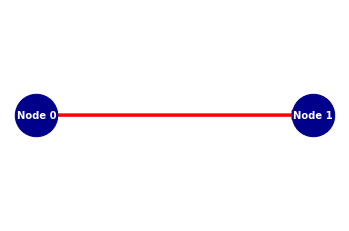

In [7]:
# draw edges, nodes and labels.
nx.draw_networkx_edges(FG,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=1800)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=10, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [8]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Waterway width for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["WaterwayWidth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))


General depth for edge ('Node 0', 'Node 1') is 6 m
Waterway width for edge ('Node 0', 'Node 1') is 150 m
Current speed for edge ('Node 0', 'Node 1') is 2 m/s
General depth for edge ('Node 1', 'Node 0') is 6 m
Waterway width for edge ('Node 1', 'Node 0') is 150 m
Current speed for edge ('Node 1', 'Node 0') is 2 m/s


#### Seting up OpenTNSim mix-in classes for simulation

In [9]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

#### Define simulation connecting vessel with sailing path

##### Define sailing paths

In [10]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[1].name)

##### connecting vessel with sailing path

In [11]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    env.process(vessel.move())
    env.run()
    
    return vessel

#### Run the simulation to get the "resistance", "power required" and "emissions (CO2, PM10, NOx)" while the vessel sailing over the waterway

##### run simulation

In [12]:
vessel_simulation_results = run_simulation(path = path, **data_vessel)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_simulation_results)
energycalculation_upstream.calculate_energy_consumption()


##### extract "sailing distance", "total resistance R_tot", "total power required P_tot","CO2 emissions", "PM10 emissions","NOx emissions"  from OpenTNSim log

In [13]:
# create dataframe from energy calculation computation
df_results = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','distance','sailing_duration','R_tot','P_tot','total_energy',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX']
            
df_results= df_results[selected]
df_results

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,distance,sailing_duration,R_tot,P_tot,total_energy,total_emission_CO2,total_emission_PM10,total_emission_NOX
0,POINT (0 0),POINT (4 0),445277.963173,98950.658483,11.024539,62.497387,1717.821568,1.368820e+06,1005.944631,24782.837037


## Assignment 1

#### Extract the emissions(CO2, PM10, NOx) indicators in g/km, g/s, g/ton-km

### g

### g/m

### g/s

### g/ton-km  
(reference vessel payload: 1500 ton)